In [81]:
from gerrychain import Graph
from geopy.distance import geodesic
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import geopandas as gpd

In [83]:
filepath = "C:/PythonSecure/CornHuskers/NE_county.json"

G = Graph.from_json( filepath )

In [85]:
for node in G.nodes:
    county_name = G.nodes[node]['NAME20']
    county_population = G.nodes[node]['P0010001']
    #Get Lat and Long Coordinates
    lat_coordinate = G.nodes[node]['INTPTLAT20']
    long_coordinate = G.nodes[node]['INTPTLON20']
    G.nodes[node]['POP100'] = county_population
    print(f"Node {node} is {county_name} County, which had a population of {county_population} and is centered at ({lat_coordinate}, {long_coordinate})")


Node 0 is Sioux County, which had a population of 1135 and is centered at (+42.4706681, -103.7321705)
Node 1 is Lincoln County, which had a population of 34676 and is centered at (+41.0503221, -100.7444808)
Node 2 is Sherman County, which had a population of 2959 and is centered at (+41.2187425, -098.9728492)
Node 3 is Logan County, which had a population of 716 and is centered at (+41.5421555, -100.4436647)
Node 4 is Merrick County, which had a population of 7668 and is centered at (+41.1697896, -098.0310573)
Node 5 is Sheridan County, which had a population of 5127 and is centered at (+42.5122888, -102.3682795)
Node 6 is Pawnee County, which had a population of 2544 and is centered at (+40.1377971, -096.2452136)
Node 7 is Sarpy County, which had a population of 190604 and is centered at (+41.1150635, -096.1091254)
Node 8 is Grant County, which had a population of 611 and is centered at (+41.9139574, -101.7559645)
Node 9 is Burt County, which had a population of 6722 and is centered a

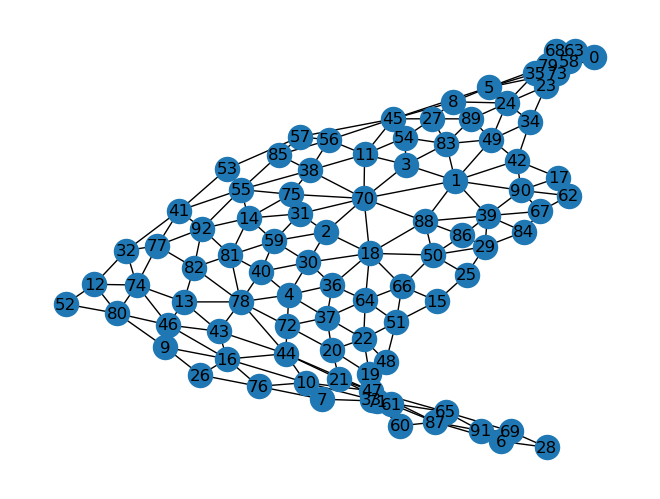

In [87]:
nx.draw(G, with_labels=True)

In [53]:
# Impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 3          # number of districts
total_population = sum(G.nodes[node]['POP100'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 650566 and U = 657103 and k = 3


In [57]:
k = 3  # desired number of districts

# create model 
md = gp.Model()

# create variables
x = md.addVars( G.nodes, k, vtype=GRB.BINARY )  # x[i,j] = 1 when county i is assigned to district j
y = md.addVar()                                 # y = population of smallest district
z = md.addVar()                                 # z = population of largest district

In [59]:
# objective is to minimize absolute population deviation
md.setObjective( z - y, GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
md.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G.nodes ) 

# add constraints saying that each district has population at least y
md.addConstrs( gp.quicksum( G.nodes[i]['POP100'] * x[i,j] for i in G.nodes ) >= y for j in range(k) )

# add constraints saying that each district has population at most z
md.addConstrs( gp.quicksum( G.nodes[i]['POP100'] * x[i,j] for i in G.nodes ) <= z for j in range(k) )

md.update()
# solve IP model
md.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99 rows, 281 columns and 843 nonzeros
Model fingerprint: 0x67efd4d8
Variable types: 2 continuous, 279 integer (279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1009121.0000
Presolve time: 0.00s
Presolved: 99 rows, 281 columns, 843 nonzeros
Variable types: 0 continuous, 281 integer (279 binary)

Root relaxation: objective -1.164153e-10, 44 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00000    0    6 100912

In [60]:
# print the absolute population deviation
print("The minimum required deviation is",md.objVal,"persons.")

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_county_names = [ [ G.nodes[i]['NAME20'] for i in district ] for district in districts ]
district_populations = [ sum( G.nodes[i]['POP100'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("The corresponding county names are =",district_county_names[j] )
    print("")

The minimum required deviation is 1.0 persons.
District 0 has these nodes = [0, 2, 4, 5, 7, 9, 10, 12, 13, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 45, 46, 48, 49, 50, 51, 52, 54, 56, 58, 59, 60, 62, 64, 66, 67, 68, 69, 70, 72, 73, 74, 75, 77, 80, 81, 83, 84, 85, 86, 87, 88, 91, 92] and this population = 653835
The corresponding county names are = ['Sioux', 'Sherman', 'Merrick', 'Sheridan', 'Sarpy', 'Burt', 'Saunders', 'Dixon', 'Stanton', 'Franklin', 'Chase', 'Fillmore', 'York', 'Seward', 'Clay', 'Cheyenne', 'Garden', 'Harlan', 'Washington', 'Hooker', 'Richardson', 'Furnas', 'Howard', 'Cedar', 'Thayer', 'Deuel', 'Morrill', 'Hamilton', 'Loup', 'Frontier', 'Nance', 'Perkins', 'Butler', 'Cherry', 'Cuming', 'Nuckolls', 'Keith', 'Phelps', 'Webster', 'Dakota', 'Thomas', 'Brown', 'Banner', 'Greeley', 'Jefferson', 'Dundy', 'Adams', 'Kearney', 'Hitchcock', 'Kimball', 'Nemaha', 'Custer', 'Polk', 'Dawes', 'Wayne', 'Garfield', 'Pierce', 'Thurs

In [93]:
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 1, 2, 3, 4, 5, 8, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 66, 67, 68, 70, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92] connected? True
Is district = [6, 7, 10, 21, 28, 47, 61, 65, 69, 71, 87, 91] connected? True
Is district = [9, 16, 26, 76, 80] connected? True


In [77]:
# print the objective value
print(md.objVal)

# get the centers (ensure the variable exists first)
centers = [ j for j in G.nodes if (j, j) in x and x[j, j].x > 0.5 ]

# retrieve district assignments
districts = [ [ i for i in G.nodes if (i, j) in x and x[i, j].x > 0.5 ] for j in centers ]

# get names and populations
district_counties = [ [ G.nodes[i]["NAME20"] for i in district ] for district in districts ]
district_populations = [ sum(G.nodes[i]["POP100"] for i in district) for district in districts ]

# print info
for j in range(len(districts)):
    print(f"District {j} has population {district_populations[j]} and contains counties {district_counties[j]}")
    print("")


1.0
District 0 has population 651067 and contains counties ['Sioux', 'Lincoln', 'Sherman', 'Logan', 'Merrick', 'Sheridan', 'Grant', 'Blaine', 'Dixon', 'Stanton', 'Wheeler', 'Franklin', 'Chase', 'Buffalo', 'Fillmore', 'York', 'Clay', 'Cheyenne', 'Garden', 'Harlan', 'Hooker', 'Furnas', 'Howard', 'Valley', 'Cedar', 'Thayer', 'Deuel', 'Morrill', 'Hall', 'Hamilton', 'Loup', 'Frontier', 'Nance', 'Knox', 'Perkins', 'Colfax', 'Butler', 'Cherry', 'Cuming', 'Nuckolls', 'Keith', 'Phelps', 'Webster', 'Dakota', 'Boyd', 'Thomas', 'Holt', 'Brown', 'Keya Paha', 'Banner', 'Greeley', 'Jefferson', 'Dundy', 'Scotts Bluff', 'Adams', 'Kearney', 'Hitchcock', 'Kimball', 'Custer', 'Polk', 'Dawes', 'Wayne', 'Garfield', 'Pierce', 'Platte', 'Box Butte', 'Boone', 'Madison', 'McPherson', 'Red Willow', 'Rock', 'Gosper', 'Dawson', 'Arthur', 'Hayes', 'Antelope']

District 1 has population 654384 and contains counties ['Pawnee', 'Sarpy', 'Saunders', 'Seward', 'Richardson', 'Lancaster', 'Saline', 'Otoe', 'Nemaha', 'Cass

In [67]:
# Create a distance dictionary
dist = {}

# Loop over all pairs of counties (nodes) in the graph
for i in G.nodes:
    name_i = G.nodes[i]['NAME20']
    lat_i = G.nodes[i]['INTPTLAT20']
    lon_i = G.nodes[i]['INTPTLON20']
    loc_i = (lat_i, lon_i)

    for j in G.nodes:
        name_j = G.nodes[j]['NAME20']
        lat_j = G.nodes[j]['INTPTLAT20']
        lon_j = G.nodes[j]['INTPTLON20']
        loc_j = (lat_j, lon_j)

        # Compute and store the geodesic distance in miles between county i and county j
        dist[(i, j)] = geodesic(loc_i, loc_j).miles

In [68]:
# create model 
mm = gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x = mm.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )
# objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
mm.setObjective( gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]['POP100'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
mm.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# add constraint saying there should be k district centers
mm.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
mm.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
mm.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
mm.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

mm.update()

In [69]:
# add contiguity constraints
DG = nx.DiGraph(G)

# add flow variables
#    f[i,j,v] = flow across arc (i,j) that is sent from souce/root v
f = mm.addVars( DG.edges, G.nodes ) 

# add constraints saying that if node i is assigned to node j, 
#   then node i must consume one unit of node j's flow
mm.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node i can receive flow of type j 
#   only if node i is assigned to node j
M = G.number_of_nodes() - 1
mm.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node j cannot receive flow of its own type
mm.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

mm.update()

mm.optimize()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 26134 rows, 51615 columns and 188238 nonzeros
Model fingerprint: 0xb962d723
Variable types: 42966 continuous, 8649 integer (8649 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+05, 9e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 293 rows and 677 columns
Presolve time: 0.77s
Presolved: 25841 rows, 50938 columns, 186722 nonzeros
Variable types: 42294 continuous, 8644 integer (8644 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root r

In [71]:
# print the objective value
print(mm.objVal)

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

9013005619.397532
District 0 has population 651067 and contains counties ['Sioux', 'Lincoln', 'Sherman', 'Logan', 'Merrick', 'Sheridan', 'Grant', 'Blaine', 'Dixon', 'Stanton', 'Wheeler', 'Franklin', 'Chase', 'Buffalo', 'Fillmore', 'York', 'Clay', 'Cheyenne', 'Garden', 'Harlan', 'Hooker', 'Furnas', 'Howard', 'Valley', 'Cedar', 'Thayer', 'Deuel', 'Morrill', 'Hall', 'Hamilton', 'Loup', 'Frontier', 'Nance', 'Knox', 'Perkins', 'Colfax', 'Butler', 'Cherry', 'Cuming', 'Nuckolls', 'Keith', 'Phelps', 'Webster', 'Dakota', 'Boyd', 'Thomas', 'Holt', 'Brown', 'Keya Paha', 'Banner', 'Greeley', 'Jefferson', 'Dundy', 'Scotts Bluff', 'Adams', 'Kearney', 'Hitchcock', 'Kimball', 'Custer', 'Polk', 'Dawes', 'Wayne', 'Garfield', 'Pierce', 'Platte', 'Box Butte', 'Boone', 'Madison', 'McPherson', 'Red Willow', 'Rock', 'Gosper', 'Dawson', 'Arthur', 'Hayes', 'Antelope']

District 1 has population 654384 and contains counties ['Pawnee', 'Sarpy', 'Saunders', 'Seward', 'Richardson', 'Lancaster', 'Saline', 'Otoe', '

In [1]:
# District populations
populations = [651067, 654384, 656053]

# Calculate the mean population
mean_pop = sum(populations) / len(populations)

# Calculate percentage deviation from the mean for each district
percent_deviations = [abs(pop - mean_pop) / mean_pop * 100 for pop in populations]

# Print the results
for i, (pop, dev) in enumerate(zip(populations, percent_deviations), start=1):
    print(f"District {i} has a population of {pop} with a deviation of {dev:.2f}% from the mean of {mean_pop:.0f}")


District 1 has a population of 651067 with a deviation of 0.42% from the mean of 653835
District 2 has a population of 654384 with a deviation of 0.08% from the mean of 653835
District 3 has a population of 656053 with a deviation of 0.34% from the mean of 653835


In [73]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = "C:/PythonSecure/CornHuskers/NE_county.shp"


# Read geopandas dataframe from file
df = gpd.read_file( filepath )

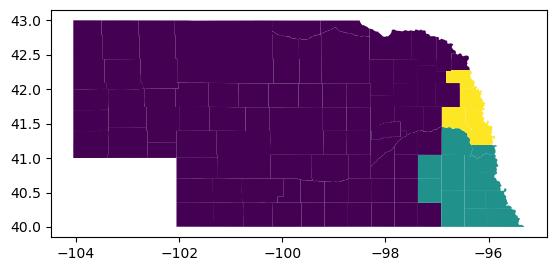

In [45]:
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()